## Training Generative Adversarial Networks(GANs) in Pytorch

Generative modeling is an unsupervised learning task in machine learning that involves automatically discovering and learning the regularities or patterns in input data in such a way that the model can be used to generate or output new examples that plausibly could have been drawn from the original dataset.

Dnn are mainly used for superviseed learning,but gans use nn for gerative modelling

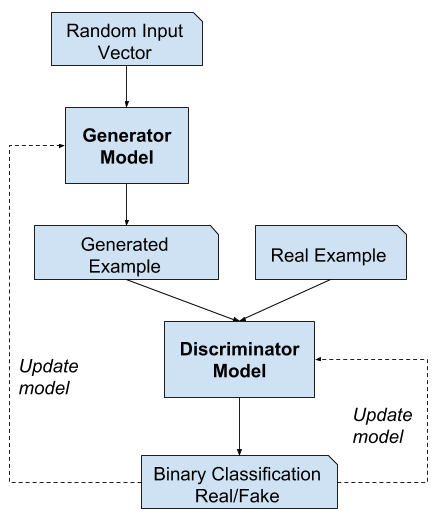

There are two neural networks: a Generator and a Discriminator. The generator generates a "fake" sample given a random vector/matrix, and the discriminator attempts to detect whether a given sample is "real" (picked from the training data) or "fake" (generated by the generator). Training happens in tandem: we train the discriminator for a few epochs, then train the generator for a few epochs, and repeat. This way both the generator and the discriminator get better at doing their jobs.

GANs however, can be notoriously difficult to train, and are extremely sensitive to hyperparameters, activation functions and regularization.

### Downloading datasets from Kaggle

In [11]:
!pip install opendatasets


In [1]:
import opendatasets as od

In [3]:
dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url,data_dir="./data")

Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset


In [126]:
import os

In [ ]:
DATA_DIR="./data/animefacedataset"
print(os.listdir(DATA_DIR))

['images']


In [130]:
print(os.listdir(DATA_DIR+"/images")[:10])

['0_2000.jpg', '10000_2004.jpg', '10001_2004.jpg', '10002_2004.jpg', '10003_2004.jpg', '10004_2004.jpg', '10005_2004.jpg', '10006_2004.jpg', '10007_2004.jpg', '10008_2004.jpg']


In [132]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid

import matplotlib.pyplot as plt


In [134]:
stats=(0.5,0.5,0.5),(0.5,0.5,0.5)

In [136]:
train_ds=ImageFolder(DATA_DIR,T.Compose([
    T.Resize(64),
    T.CenterCrop(64),
    T.ToTensor(),
    T.Normalize(*stats)
]))

In [137]:
len(train_ds)

63565

In [140]:
print(train_ds[0])
train_ds.classes

(tensor([[[ 0.6784,  0.6706,  0.8275,  ...,  1.0000,  0.9922,  0.9765],
         [ 0.8431,  0.9294,  0.9922,  ...,  0.9922,  0.9922,  1.0000],
         [ 0.9216,  0.9843,  0.9922,  ...,  0.9843,  0.9922,  1.0000],
         ...,
         [-0.0902, -0.1216, -0.2549,  ..., -0.1373, -0.2784, -0.5294],
         [-0.0510, -0.1451, -0.2941,  ..., -0.1529, -0.3020, -0.5922],
         [-0.0431, -0.1451, -0.3176,  ..., -0.2235, -0.3569, -0.6471]],

        [[ 0.6549,  0.6471,  0.7725,  ...,  0.7882,  0.7725,  0.7569],
         [ 0.8118,  0.8902,  0.9765,  ...,  0.7333,  0.7569,  0.7882],
         [ 0.8510,  0.9137,  0.9137,  ...,  0.7020,  0.7255,  0.7725],
         ...,
         [-0.1686, -0.1843, -0.3255,  ..., -0.2392, -0.3804, -0.6157],
         [-0.1451, -0.2235, -0.3725,  ..., -0.2549, -0.4039, -0.6784],
         [-0.1529, -0.2392, -0.3961,  ..., -0.3020, -0.4353, -0.7333]],

        [[ 0.6157,  0.5922,  0.7255,  ...,  0.7490,  0.7412,  0.7333],
         [ 0.7647,  0.8431,  0.9137,  ...,  

['images']

In [142]:
train_dl=DataLoader(train_ds,batch_size=128,shuffle=True,num_workers=3,pin_memory=True)

In [144]:
def denorm(images):
    mean=stats[0]
    std=stats[1]
    mean=torch.tensor(mean).view(1,3,1,1)
    std=torch.tensor(std).view(1,3,1,1)
    return images*std+mean


In [154]:
def show_images(images,nmax=64):
    plt.figure(figsize=(8,8))
    plt.imshow(make_grid(denorm(images.detach()[:nmax]),nrow=8).permute(1,2,0))
    plt.axis("off")
def show_batch(dl,nmax=64):
    for images,_ in dl:
        show_images(images)
        break

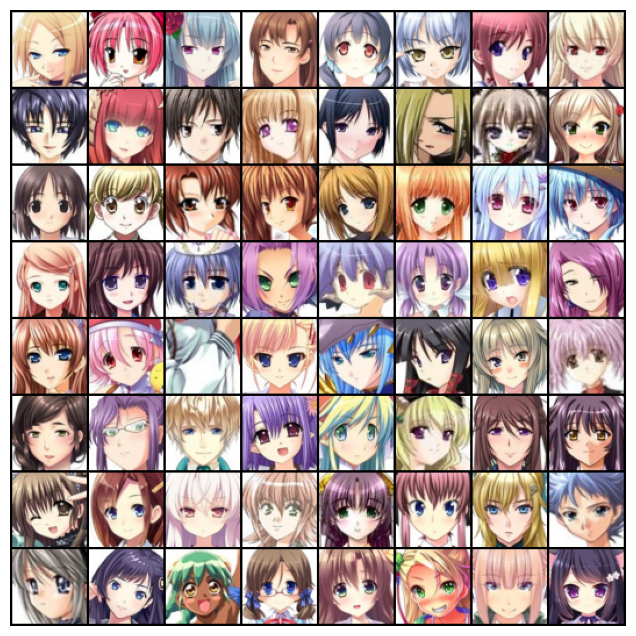

In [156]:
show_batch(train_dl)

### Using a GPU

In [92]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")
        

In [116]:
def to_device(data,device):
    if isinstance (data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

In [98]:
class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl=dl
        self.device=device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)
    def __len__(self):
        return len(self.dl)
    

In [106]:
device=get_default_device()
device

device(type='cuda')

In [108]:
train_dl=DeviceDataLoader(train_dl,device)

## Discriminator Network

The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. We'll use a convolutional neural networks (CNN) which outputs a single number output for every image. We'll use stride of 2 to progressively reduce the size of the output feature map.

In [162]:
discriminator=nn.Sequential(
    #3X64X64
    nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2,inplace=True),

    #64X32X32

    nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2,inplace=True),

    #128X16X16
    

    nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2,inplace=True),

    #256X8X8

    nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2,inplace=True),

    #512X4X4

    nn.Conv2d(512,1,kernel_size=4,stride=1,padding=0,bias=False),
    #1X1X1
    
    nn.Flatten(),
    nn.Sigmoid()
    
)

#the output of the discriminator interpreted as probablity of input image being real 

In [164]:
discriminator=to_device(discriminator,device)

## Generator Network

Input to the generator network is a vector or matrix of random numbers (letent tensor) which is used to gen image

 The generator will convert a latent tensor of shape (128, 1, 1) into an image tensor of shape 3 x 28 x 28. To achive this, we'll use the ConvTranspose2d layer from PyTorch, which is performs to as a transposed convolution (also referred to as a deconvolution)

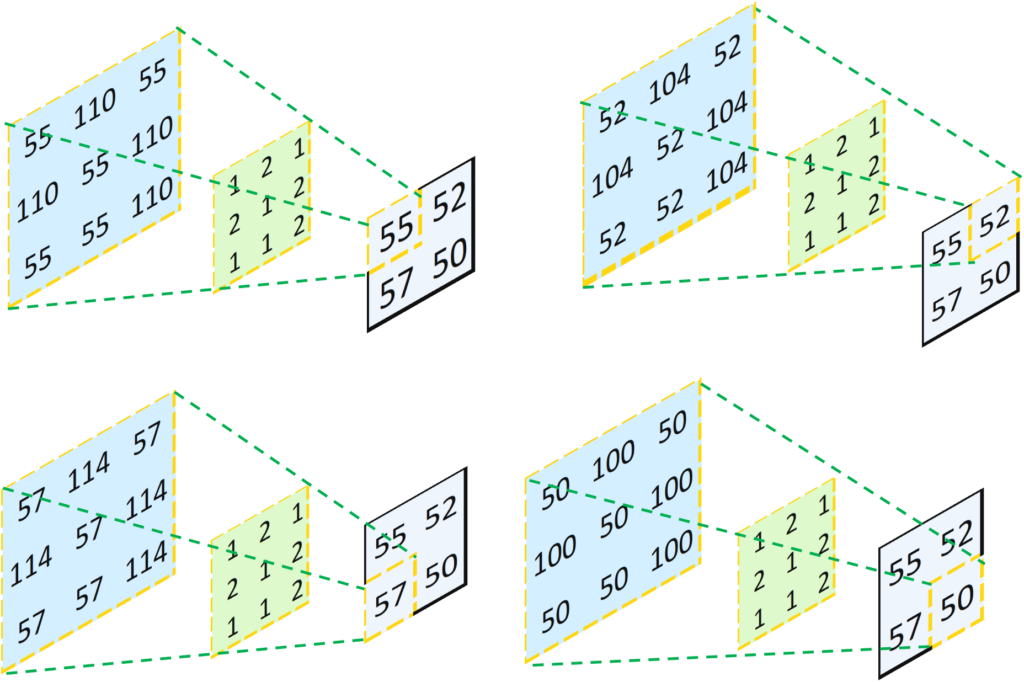

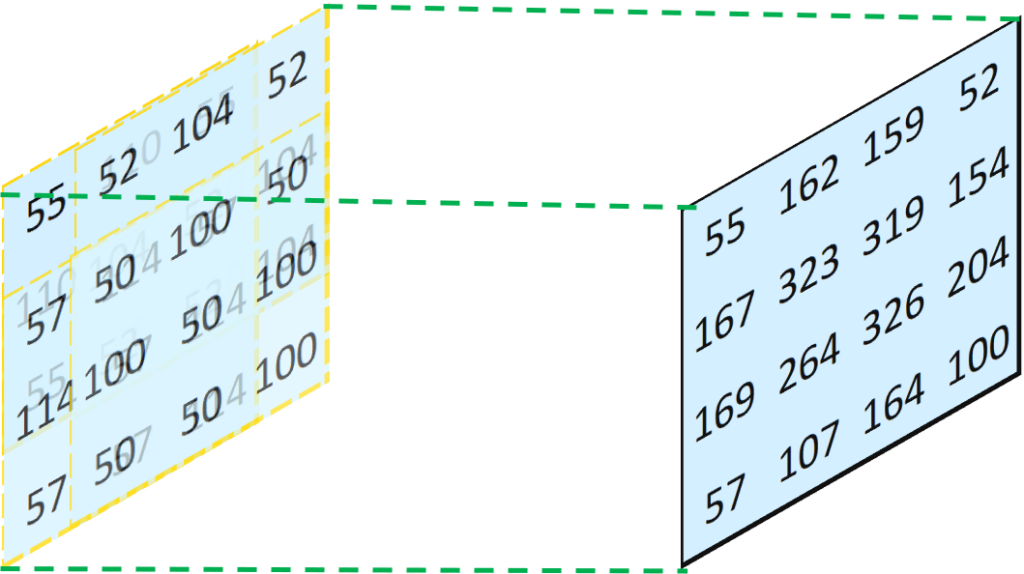

https://towardsdatascience.com/understand-transposed-convolutions-and-build-your-own-transposed-convolution-layer-from-scratch-4f5d97b2967/

In [170]:
#here 3X3 image converted to 5X5 feature map,each pixel is padded 

In [172]:
latent_size=128


In [ ]:
generator=nn.Sequential(
    nn.ConvTranspose2d(latent_size,512,kernel_size=4,stride=1,padding=0,bias=False)
)